In [1]:
pip install transformers==4.38.2 datasets==2.18.0 evaluate==0.4.1 sacrebleu==2.4.2 tensorflow==2.16.1 tf-keras==2.16.0 matplotlib==3.7.1

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIR = '/content/gdrive/My Drive/Dataset'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import re

import evaluate
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict, Translation
from transformers.keras_callbacks import PushToHubCallback, KerasMetricCallback
from transformers import pipeline, AutoTokenizer, AdamWeightDecay, TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
import pandas as pd
import datasets as Dataset

In [4]:
SRC_LANG = "dyu"
TRG_LANG = "fr"
CHARS_TO_REMOVE_REGEX = '[!"&\(\),-./:;=?+.\n\[\]]'
PREFIX = "translate Dyula to French: " # This command will have to be passed to the model during inference so it knows what to do
MODEL_CHECKPOINT = "t5-small"
HF_REPO_NAME = "dyu-fr-t5"
LOCAL_SAVE_DIR = "../saved_model"
TRAIN_EPOCHS = 50

In [5]:
train_path = ROOT_DIR + "/train-00000-of-00001.csv"
val_path = ROOT_DIR + "/validation-00000-of-00001.csv"

In [6]:
import re
import ast
from datasets import load_dataset

# Define the source and target languages
SRC_LANG = "dyu"  # example source language
TRG_LANG = "fr"   # example target language
CHARS_TO_REMOVE_REGEX = r"[^\w\s]"  # regex to remove special characters

from datasets import load_dataset, DatasetDict

# Load training and test datasets
dataset = DatasetDict({
    "train": load_dataset("csv", data_files = train_path, delimiter="|", index_col=0)["train"],
    "validation": load_dataset("csv", data_files= val_path, delimiter="|", index_col=0)["train"]
})

# Remove unnecessary column from both splits
dataset = dataset.map(lambda example: {k: v for k, v in example.items() if k != "__index_level_0__"})
dataset = dataset.remove_columns(["__index_level_0__"])


# Clean data (lowercase and punctuation)
def remove_special_characters(text):
    text = re.sub(CHARS_TO_REMOVE_REGEX, " ", text.lower())
    return text.strip()

def clean_text(batch):
    # Convert the string representation of the dictionary to an actual dictionary
    try:
        translation = ast.literal_eval(batch["translation"])
    except ValueError as e:
        print(f"Error evaluating translation: {e}")
        translation = {}

    # Ensure 'translation' is a dictionary and has the right keys
    if isinstance(translation, dict):
        # Clean source language and target language texts
        translation[SRC_LANG] = remove_special_characters(translation.get(SRC_LANG, ""))
        translation[TRG_LANG] = remove_special_characters(translation.get(TRG_LANG, ""))
        # Update the batch with cleaned translation
        batch["translation"] = translation
    else:
        print(f"Warning: 'translation' is not a dictionary for the batch {batch}")
    return batch

# Apply the clean_text function to each batch
dataset = dataset.map(clean_text)

# Inspect the cleaned dataset
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['ID', 'translation'],
        num_rows: 8065
    })
    validation: Dataset({
        features: ['ID', 'translation'],
        num_rows: 1471
    })
})


In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
def preprocess_function(examples):
    inputs = [PREFIX + example[SRC_LANG] for example in examples["translation"]]
    targets = [example[TRG_LANG] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

In [9]:
tokenized_books = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1471 [00:00<?, ? examples/s]

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=MODEL_CHECKPOINT, return_tensors="tf")

In [11]:
 metric = evaluate.load("sacrebleu")

In [12]:
def postprocess_text(preds, labels):
     preds = [pred.strip() for pred in preds]
     labels = [[label.strip()] for label in labels]

     return preds, labels

def compute_metrics(eval_preds):
     preds, labels = eval_preds
     if isinstance(preds, tuple):
         preds = preds[0]
     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

     labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
     decoded_labels = labels

     decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

     result = metric.compute(predictions=decoded_preds, references=decoded_labels)
     result = {"bleu": result["score"]}

     prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
     result["gen_len"] = np.mean(prediction_lens)
     result = {k: round(v, 4) for k, v in result.items()}
     return result

In [13]:
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

In [14]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [15]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_books["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_books["validation"],
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator,
)

In [16]:
model.compile(optimizer=optimizer)  # No loss argument!

In [18]:
%%time
train_hist = model.fit(
  x=tf_train_set,
 # validation_split = 0.2,
 validation_data=tf_test_set,
  epochs=40,
)

Epoch 1/40


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
252/252 [==============================] - 174s 334ms/step - loss: 3.9341 - val_loss: 3.4147
Epoch 2/40
252/252 [==============================] - 62s 244ms/step - loss: 3.6457 - val_loss: 3.2986
Epoch 3/40
252/252 [==============================] - 63s 249ms/step - loss: 3.5441 - val_loss: 3.2279
Epoch 4/40
252/252 [==============================] - 63s 249ms/step - loss: 3.4758 - val_loss: 3.1759
Epoch 5/40
252/252 [==============================] - 63s 249ms/step - loss: 3.4198 - val_loss: 3.1322
Epoch 6/40
252/252 [==============================] - 64s 254ms/step - loss: 3.3762 - val_loss: 3.1000
Epoch 7/40
252/252 [==============================] - 64s 255ms/step - loss: 3.3303 - val_loss: 3.0676
Epoch 8/40
252/252 [==============================] - 64s 255ms/step - loss: 3.2957 - val_loss: 3.0437
Epoch 9/40
252/252 [============================

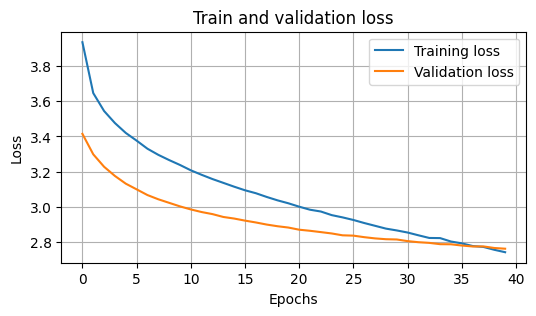

In [19]:
plt.figure(figsize=(6,3))
plt.plot(train_hist.history["loss"], label="Training loss")
plt.plot(train_hist.history["val_loss"], label="Validation loss")
plt.title("Train and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [20]:
tokenizer.save_pretrained(ROOT_DIR)
model.save_pretrained(ROOT_DIR)

In [22]:
import os
MODEL_DIR = os.path.join(ROOT_DIR, "dyu-fr-model")

# Save tokenizer and model in the specified subfolder
tokenizer.save_pretrained(MODEL_DIR)
model.save_pretrained(MODEL_DIR)